In [18]:
def mega_function(username, playlist_uri):

    #libraries
    import spotipy
    from spotipy.oauth2 import SpotifyClientCredentials
    import spotipy.util as util
    import json
    import numpy as np
    import pandas as pd

    import matplotlib.pyplot as plt
    import seaborn as sns
    import seaborn as sb
    %matplotlib inline
    import plotly.express as px
    import pdfkit
    import plotly.figure_factory as ff

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import NearestNeighbors
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import metrics
    from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.linear_model import LogisticRegression
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.model_selection import GridSearchCV
    from yellowbrick.cluster import KElbowVisualizer
    from sklearn.cluster import KMeans
    from sklearn.datasets import make_blobs
    from mpl_toolkits.mplot3d import Axes3D
    from scipy.spatial.transform import Rotation as R
    import scipy.cluster.hierarchy as shc
    from scipy.spatial import KDTree
    from sklearn.preprocessing import MinMaxScaler

    from matplotlib.backends.backend_pdf import PdfPages
    import statsmodels.api as sm
    from scipy import stats
    from scipy.stats import ttest_1samp, ttest_rel, ttest_ind
    from IPython.display import display, Image, SVG, Math, YouTubeVideo
    
    #Spotify API
    my_username = 'britopereiraa'
    client_id ='17a3ed14ab434b33b28f19f8bea3337d'
    client_secret = '7f848f9d2a024b15be5fa776b4dc7a05'
    redirect_uri = 'http://localhost:7777/callback'
    scope = 'user-read-recently-played'

    token = util.prompt_for_user_token(username=my_username, 
                                       scope=scope, 
                                       client_id=client_id,   
                                       client_secret=client_secret,     
                                       redirect_uri=redirect_uri)

    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret) 
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
    
    
    def master_function(username, uri):
        uri = playlist_uri    
        username = username
        playlist_id = uri
        results = {'items':[]}

        for n in range(0,3000,100):
            new = sp.user_playlist_tracks(username, playlist_id,  offset = n)
            results['items'] += new['items']

            playlist_tracks_data = results
            playlist_tracks_id = []
            playlist_tracks_titles = []
            playlist_tracks_artists = []

            for track in playlist_tracks_data['items']:
                playlist_tracks_id.append(track['track']['id'])
                playlist_tracks_titles.append(track['track']['name'])

            #adds a list of all artists involved in the song to the list of artists for the playlist
                for artist in track['track']['artists']:
                    artist_list = []
                    artist_list.append(artist['name'])
                playlist_tracks_artists.append(artist_list[0])

        #some tracks might have none id
        playlist_tracks_id = list(filter(None, playlist_tracks_id)) 

        df = pd.DataFrame([])
        for i in range(0, len(playlist_tracks_id)):
            features = sp.audio_features(playlist_tracks_id[i])
            features_df = pd.DataFrame(features)
            df = df.append(features_df)


        df['title'] = playlist_tracks_titles
        #features_df['first_artist'] = playlist_tracks_first_artists
        df['main_artist'] = playlist_tracks_artists
        #features_df = features_df.set_index('id')
        df = df[['id', 'title', 'main_artist',
                                   'danceability', 'energy', 'key', 'loudness',
                                   'mode', 'acousticness', 'instrumentalness',
                                   'liveness', 'valence', 'tempo',
                                   'duration_ms', 'time_signature']]
        return df

    
    df = master_function(username,playlist_uri)
    df = df.reset_index()
    df = df.drop(columns=['index'])
    
    features = ['danceability', 'energy', 'key','loudness', 'mode', 'acousticness', 'instrumentalness', 'liveness','valence', 'tempo']

    #################   all songs playlist    #################
    all_songs = pd.read_csv('../data/all_songs.csv')
    
    #drop duplicates
    all_songs.drop_duplicates(subset ="id", keep = False, inplace = True)

    #check recomended songs that are not in the playlist already:
    all_songs = all_songs.loc[~((all_songs.id.isin(df['id']))),:]

    #################   UNSUPERVIZED ML - PCA    #################
    scaler = StandardScaler()
    scaler.fit(all_songs[features])
    all_songs_features_scaled = scaler.transform(all_songs[features])
    
    #PCA with all songs playlist
    pca = PCA(n_components=3, random_state=42)
    df_pca_all_songs = pd.DataFrame(data=pca.fit_transform(all_songs_features_scaled), columns=['PC1','PC2','PC3'])
    df_pca_all_songs = df_pca_all_songs.merge(all_songs, left_index=True, right_index=True)
    df_pca_all_songs = df_pca_all_songs[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]
    
    #PCA with friend's playlist

    #features scaling 
    df_scaled = scaler.transform(df[features])

    #use trained PCA
    df_pca = pd.DataFrame(data=pca.transform(df_scaled), columns=['PC1','PC2','PC3'])
    
    df_pca = df_pca.merge(df, left_index=True, right_index=True)
    df_pca = df_pca[['PC1', 'PC2', 'PC3', 'title', 'main_artist']]
    
    
    #################   GET RECOMENDATIONS    #################
    columns = ['PC1', 'PC2', 'PC3']
    kdB = KDTree(df_pca_all_songs[columns].values)#all songs
    neighbours = kdB.query(df_pca[columns].values, k=1)[-1] #k desired number of neighbors: this case I chose 1 neighbour song
    #returns indices of 1-neighbors for all rows/points in our songs "database"
    
    recomendations = all_songs[all_songs.index.isin(neighbours[:31])]
    recomendations_output = recomendations[['title', 'main_artist']]
    recomendations_output.columns = ['Song Recommendation', 'Artist']
    #recomendations_output = recomendations_output.style.set_caption("Songs you might like:")
    recomendations_output

    #export pdf
    f = open('exp.html','w')
    a = recomendations_output.to_html()
    f.write(a)
    f.close()

    pdfkit.from_file('exp.html', 'Recommendations.pdf')
    
    #################   Exploratory Data Analysis    #################
    
    obamas = pd.read_csv('../data/obamas.csv')
    pitchfork = pd.read_csv('../data/pitchfork.csv')
    billboard = pd.read_csv('../data/billboard.csv')
    
    obamas['Playlist'] = 'The Obamas'
    pitchfork['Playlist'] = 'Pitchfork'
    billboard['Playlist'] = 'Billboard Top 100'
    df['Playlist'] = 'Your Songs'
    
    frames = [billboard, pitchfork, obamas, df]
    data = pd.concat(frames)
    data = data.reset_index()
    data = data.drop(columns=['index'])
    


    #POLAR GRAPH
    data_scaled = pd.DataFrame(MinMaxScaler().fit_transform(data[features]), 
                             columns=data[features].columns)
    data_scaled['Playlist'] = data['Playlist']

    df_radar = data_scaled.groupby('Playlist').mean().reset_index() \
                        .melt(id_vars='Playlist', var_name="features", value_name="avg") \
                        .sort_values(by=['Playlist','features']).reset_index(drop=True)

    fig = px.line_polar(df_radar, 
                  r="avg", 
                  theta="features", 
                  title='Mean Values of Each Playlist Features',
                  color="Playlist", 
                  line_close=True,
                  line_shape='spline',
                  range_r=[0, 0.9],
                  color_discrete_sequence=px.colors.cyclical.mygbm[:-6])
    fig.show()
    
    pdf_1 = fig.write_image("fig1.pdf")
    
    
    Image(filename='../images/new_highfid.png',width = 500)

    
    ################   Hipster or Mainstream?   ################
    def big_graph(feature, label1="", label2="", label3 = ""):
        sns.kdeplot(data[data['Playlist']=='Your Songs'][feature],label=label1)
        sns.kdeplot(data[data['Playlist']=='Pitchfork'][feature],label=label2)
        sns.kdeplot(data[data['Playlist']=='Billboard Top 100'][feature],label=label3)

        plt.title(feature)
        plt.grid(b=None)

    plots =[]    

    plt.figure(figsize=(16,16))
    plt.suptitle("Hipster or Mainstream?", fontsize="x-large")

    for i, f in enumerate(features):
        plt.subplot(4,4,i+1)
        if ((i+1)% 4 == 0) or (i+1==len(features)):
            big_graph(f,label1="Your Songs", label2="Pitchfork", label3="Billboard Top 100")
        else:
            big_graph(f)

    plots.append(plt.gca())
        
    Image(filename='../images/old_highfid.png',width = 300)

    ################   You a Obama?  ################
    def big_graph2(feature, label1="", label2=""):
        sns.kdeplot(data[data['Playlist']=='Your Songs'][feature],label=label1)
        sns.kdeplot(data[data['Playlist']=='The Obamas'][feature],label=label2)
        plt.title(feature)
        plt.grid(b=None)

    plt.figure(figsize=(16,16))
    plt.suptitle("You an Obama?", fontsize="x-large")


    for i, f in enumerate(features):
        plt.subplot(4,4,i+1)
        if ((i+1)% 4 == 0) or (i+1==len(features)):
            big_graph2(f,label1="Your Songs", label2="The Obamas")
        else:
            big_graph2(f)

    plots.append(plt.gca())

    #create pdf with Graphs

    plotsFile = 'plots.pdf'

    with PdfPages(plotsFile) as pdf:
        for f in plots:
            pdf.savefig(f.get_figure(),bbox_inches='tight',pad_inches=1)  
        Image(filename='../images/obamas.png', width = 500)
    
    ################   FINAL PDF  ################   
    import PyPDF2 

    # Open the files that have to be merged one by one
    pdf1File = open('base_pdf.pdf', 'rb')
    pdf2File = open('fig1.pdf', 'rb')
    pdf3File = open('plots.pdf', 'rb')
    pdf4File = open('Recommendations.pdf', 'rb')

    # Read the files that you have opened
    pdf1Reader = PyPDF2.PdfFileReader(pdf1File)
    pdf2Reader = PyPDF2.PdfFileReader(pdf2File)
    pdf3Reader = PyPDF2.PdfFileReader(pdf3File)
    pdf4Reader = PyPDF2.PdfFileReader(pdf4File)

    # Create a new PdfFileWriter object which represents a blank PDF document
    pdfWriter = PyPDF2.PdfFileWriter()

    # Loop through all the pagenumbers for the first document
    for pageNum in range(pdf1Reader.numPages):
        pageObj = pdf1Reader.getPage(pageNum)
        pdfWriter.addPage(pageObj)

        # Loop through all the pagenumbers for the second document
    for pageNum in range(pdf2Reader.numPages):
        pageObj = pdf2Reader.getPage(pageNum)
        pdfWriter.addPage(pageObj)

    for pageNum in range(pdf3Reader.numPages):
        pageObj = pdf3Reader.getPage(pageNum)
        pdfWriter.addPage(pageObj)

    for pageNum in range(pdf4Reader.numPages):
        pageObj = pdf4Reader.getPage(pageNum)
        pdfWriter.addPage(pageObj)

        #Now that you have copied all the pages in both the documents, write them into the a new document
    pdfOutputFile = open('Ouput Report.pdf', 'wb')
    pdfWriter.write(pdfOutputFile)


    # Close all the files - Created as well as opened
    pdfOutputFile.close()
    pdf1File.close()
    pdf2File.close()
    pdf3File.close()
    pdf4File.close()

    print("Find below songs you might like:")  
    return recomendations_output

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


Find below songs you might like:


,Song Recommendation,Artist
53,Do You Know Me,John Mayer
453,Blade (Tidal Wave of Love) - Demo,Ben Khan
473,I Got It,Alena
753,Leave Me Alone,Shay Lia
910,Right Next Door (Because Of Me),Robert Cray
1229,Heart's Desire,Don Blackman
1494,Canto De Xangô,Vinícius de Moraes
1537,Cloudy Day,c.alma
1653,Escargot Blues,Guantanamo Bay Surf Club
1714,Forrest Gump,Frank Ocean


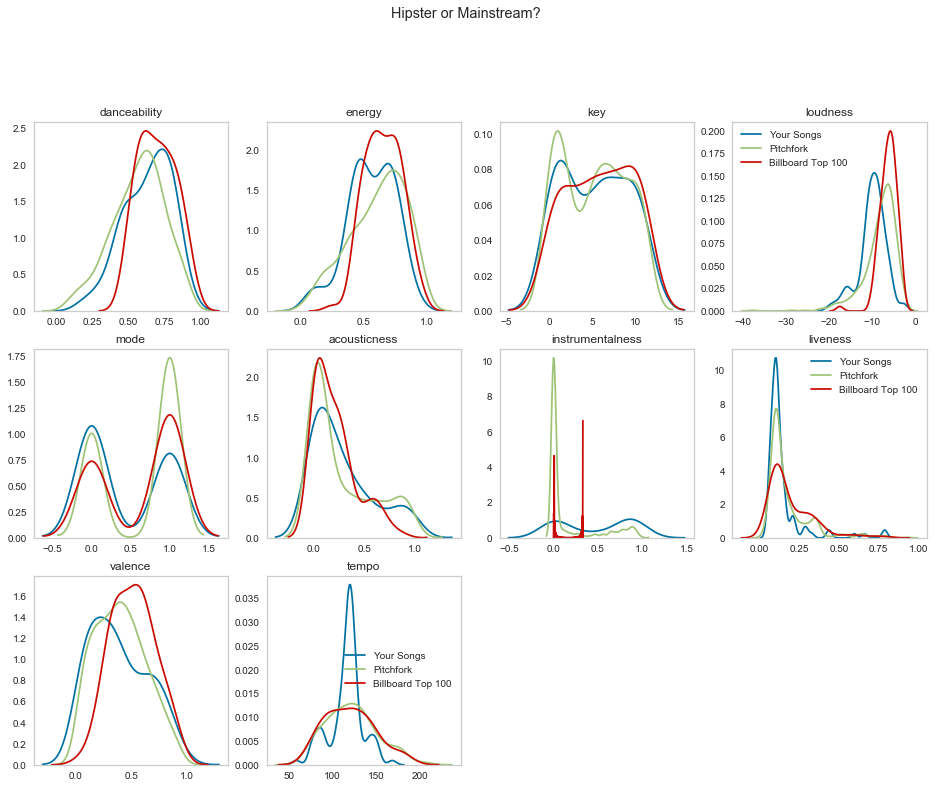

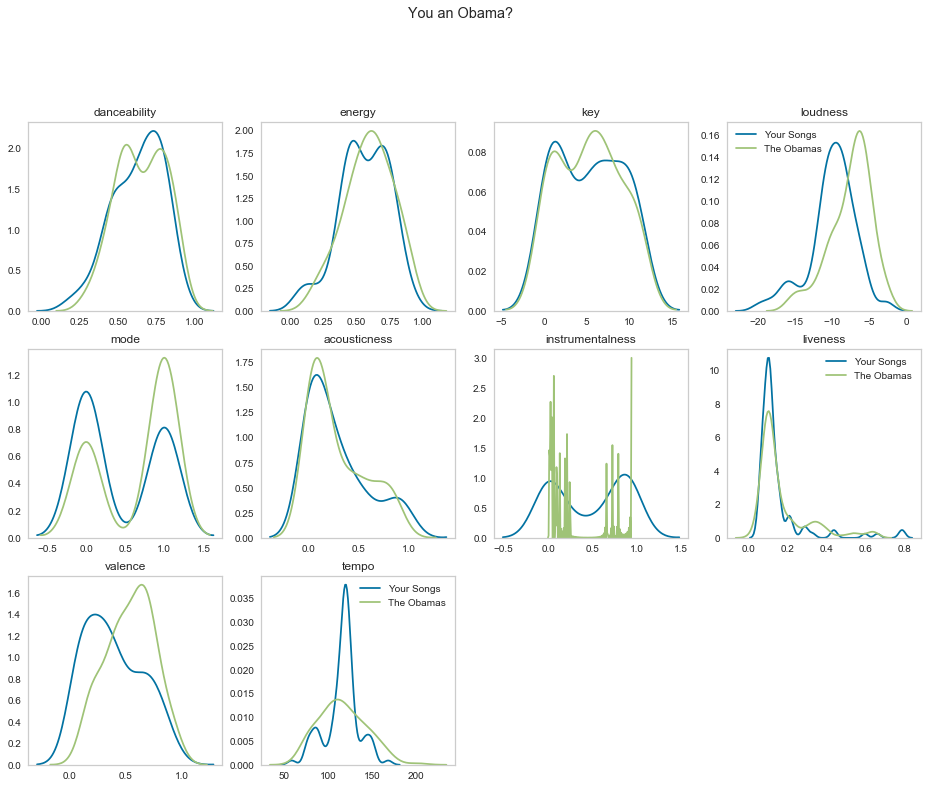

In [20]:
#input variables
playlist_uri = "37i9dQZF1EtfHjm6n4Z18E"

#Ines Top Songs 2019

username ="Inês"
      
mega_function(username, playlist_uri)
